<a href="https://colab.research.google.com/github/vsaengerderache/scour_ai/blob/main/scour_ai_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [38]:
# import library

from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
import geopandas as gpd
import seaborn as sns
from pprint import pprint
import math

In [39]:
# connect to drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Upload dataset

In [40]:
# path to shared folder with the dataset
%cd '/content/drive/My Drive/shared_folder_scour_ai'

!ls # show files in folder

/content/drive/My Drive/shared_folder_scour_ai
colab_git_workflow.ipynb  original_data.xls  README.md		  variables_RF.xlsx
datos_RF2.xlsx		  papers	     scour_ai_main.ipynb  zmax_ende_formeln


In [41]:
# read dataset
df = pd.read_excel('original_data.xls')
df = df.iloc[1:].reset_index(drop=True) # delete first row
df = df.rename(columns={ # rename columns
    'id': 'id',
    'Autor': 'author',
    'Denominación': 'denomination',
    'scour depth': 'ymax',
    'pier diameter': 'b',
    'flow depth (m)': 'h',
    'flow velocity (m/s)': 'v',
    'particle diameter (m)': 'd50',
    'Dichte t/m3': 'density_t_m3',
    'sigma (-)': 'sigma',
    'Número': 'number',
    'Unnamed: 10': 'extra_column'
})
 # create id col
df['id'] = range(1, len(df) + 1)
df = df[['id'] + [col for col in df.columns if col != 'id']]

# replace - and 999 by NA
df = df.where(~df.isin(['-', 999]), pd.NA)

 # convert columns to numeric where possible
numeric_cols = ['ymax', 'b', 'h', 'v', 'd50', 'density_t_m3', 'sigma', 'number', 'extra_column']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

display(df) # display
print(df.dtypes) # types

,id,author,denomination,ymax,b,h,v,d50,density_t_m3,sigma,number,extra_column
0,1,Melville and Chiew (1999),N1,0.094,0.0700,0.20,0.231,0.96,1.65,1.00,131.0,2.0
1,2,Melville and Chiew (1999),N2,0.077,0.0700,0.07,0.245,0.96,1.65,1.00,132.0,2.0
2,3,Melville and Chiew (1999),N3,0.069,0.0700,0.07,0.218,0.96,1.65,1.00,133.0,2.0
3,4,Melville and Chiew (1999),N4,0.079,0.0700,0.07,0.231,0.96,1.65,1.00,134.0,2.0
4,5,Melville and Chiew (1999),N5,0.039,0.0700,0.07,0.198,0.96,1.65,1.00,135.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
431,432,Chee (1982),1,NaN,0.0795,0.10,0.170,0.38,1.65,1.22,NaN,NaN
432,433,Chee (1982),2,NaN,0.1016,0.10,0.170,0.38,1.65,1.22,NaN,NaN
433,434,Chee (1982),3,NaN,0.0795,0.10,0.210,0.38,1.65,1.22,NaN,NaN
434,435,Chee (1982),4,NaN,0.1016,0.10,0.210,0.38,1.65,1.22,NaN,NaN


id                int64
author           object
denomination     object
ymax            float64
b               float64
h               float64
v               float64
d50             float64
density_t_m3    float64
sigma           float64
number          float64
extra_column    float64
dtype: object


* ymax (m) (scour depth max)
* b (m) (pier diameter)
* h (m) (flow depth)
* v (m/s) (flow velocity)
* d50 (mm) (particle diameter)
* sigma (geometric standard deviation)

# Processing data

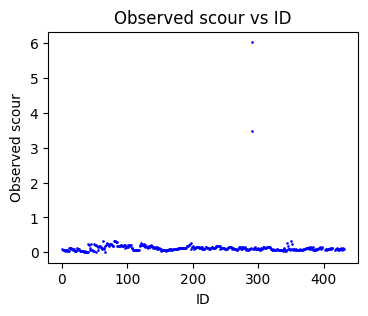

In [42]:
# plot observed scour vs id
plt.figure(figsize=(4, 3))
df = df.dropna(subset=['id', 'ymax'])
plt.scatter(df['id'], df['ymax'], color='b', s=0.8)
plt.xlabel('ID')
plt.ylabel('Observed scour')
plt.title('Observed scour vs ID')
plt.show()

In [43]:
# @title Detect duplicates
duplicates = df[df.duplicated()]

# check if there are any duplicates
if not duplicates.empty:
    print('Warning: Duplicate values found in the dataset')
    display(duplicates)
else:
    print('No duplicate values found in the dataset')

No duplicate values found in the dataset


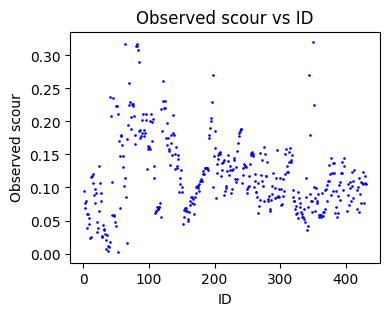

In [44]:
# @title Delete outliers
df = df[~df['ymax'].isin(df['ymax'].nlargest(2))]  # delete two largest values

# observed scour vs id
plt.figure(figsize=(4, 3))
plt.scatter(df['id'], df['ymax'], color='b', s=0.8)
plt.xlabel('ID')
plt.ylabel('Observed scour')
plt.title('Observed scour vs ID')
plt.show()

# Variable definitions

In [45]:
g = 9.81  # gravity acceleration (m/s^2)
delta = 1.65  # relative density: (solid density - water density) / water density
nu = 0.000001  # kinematic viscosity (m2/s)

# Intermediate calculations

In [46]:
df['g'] = g
df['delta'] = delta
df['nu'] = nu

df['w'] = 11 / df['d50'] * nu * (df['b']**3 * 0.01 + 1)**0.5 - 1
df['fr'] = df['v'] / (df['g'] * df['h'])**0.5 # froude
df['b_d50'] = df['b'] / df['d50']
df['h_b'] = df['h'] / df['b']
df['obs_dimensionless'] = df['ymax'] / df['b']

display(df)

,id,author,denomination,ymax,b,h,v,d50,density_t_m3,sigma,number,extra_column,g,delta,nu,w,fr,b_d50,h_b,obs_dimensionless
0,1,Melville and Chiew (1999),N1,0.094,0.0700,0.20,0.231,0.96,1.65,1.0,131.0,2.0,9.81,1.65,0.000001,-0.999989,0.164916,0.072917,2.857143,1.342857
1,2,Melville and Chiew (1999),N2,0.077,0.0700,0.07,0.245,0.96,1.65,1.0,132.0,2.0,9.81,1.65,0.000001,-0.999989,0.295653,0.072917,1.000000,1.100000
2,3,Melville and Chiew (1999),N3,0.069,0.0700,0.07,0.218,0.96,1.65,1.0,133.0,2.0,9.81,1.65,0.000001,-0.999989,0.263071,0.072917,1.000000,0.985714
3,4,Melville and Chiew (1999),N4,0.079,0.0700,0.07,0.231,0.96,1.65,1.0,134.0,2.0,9.81,1.65,0.000001,-0.999989,0.278759,0.072917,1.000000,1.128571
4,5,Melville and Chiew (1999),N5,0.039,0.0700,0.07,0.198,0.96,1.65,1.0,135.0,2.0,9.81,1.65,0.000001,-0.999989,0.238936,0.072917,1.000000,0.557143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,427,Chee (1982),75,0.123,0.1016,0.10,1.050,1.40,1.65,1.3,NaN,NaN,9.81,1.65,0.000001,-0.999992,1.060119,0.072571,0.984252,1.210630
427,428,Chee (1982),76,0.077,0.0508,0.10,1.200,1.40,1.65,1.3,NaN,NaN,9.81,1.65,0.000001,-0.999992,1.211565,0.036286,1.968504,1.515748
428,429,Chee (1982),77,0.107,0.0795,0.10,1.200,1.40,1.65,1.3,NaN,NaN,9.81,1.65,0.000001,-0.999992,1.211565,0.056786,1.257862,1.345912
429,430,Chee (1982),78,0.117,0.1016,0.10,1.200,1.40,1.65,1.3,NaN,NaN,9.81,1.65,0.000001,-0.999992,1.211565,0.072571,0.984252,1.151575


In [47]:
# vcr acording to Neill 1973
def calculate_vcr_n(d50, h):
    if d50 < 0.0009:
        theta_s = 0.0019 * d50**(-0.384)
    elif 0.0009 <= d50 <= 0.020:
        theta_s = 0.0942 * d50**(0.175)
    else:
        theta_s = 0.047

    vcr_n = (theta_s)**0.5 * 31.08 * h**(1/6) * d50**(1/3)
    return vcr_n

# vcr estimated from Shields 1936
"""https://doi.org/10.1061/(ASCE)HY.1943-7900.0000800"""
""" https://drive.google.com/file/d/1Bt9rjmcilpVrn8minHE_v-1iR984_Raz/view"""
def calculate_vcr_shields(d50, h):
  y_1 = h
  d50 = d50 / 1000
  "eq. (11)"
  u_asterisk = (16.2*d50*((9.09*10**(-6)/d50)-d50*(38.76+9.6*np.log(d50))-0.005))**0.5
  "eq. (12)"
  r = u_asterisk * d50 / (2.32*10**(-7))

  if 5 <= r and r <= 70:
    v_c = 2.5 * u_asterisk * np.log(73.5*y_1/(d50*(r*(2.85-0.58*np.log(r)+0.002*r)+111/r-6)))
  elif r > 70:
    v_c = 2.5 * u_asterisk * np.log(2.21*y_1/d50)
  elif r < 5:
    v_c = np.nan

  return(v_c)
df['vcr_shields'] = df.apply(lambda row: calculate_vcr_shields(row['d50'], row['h']), axis=1)

# vcr estimated from Shields 1936
def calculate_vcr(d50, g, delta, nu): # revisar cambiar nombre
    d50_m = d50 / 1000  # convert d50 to m
    vcr = 1.4 * (2 * (g * delta * d50_m) ** 0.5 + 10.5 * nu / d50_m)
    return vcr

# apply functions vcr to df
df['vcr_n'] = df.apply(lambda row: calculate_vcr_n(row['d50'], row['h']), axis=1)
df['vcr_shields'] = df.apply(lambda row: calculate_vcr_shields(row['d50'], row['h']), axis=1)
df['vcr'] = df.apply(lambda row: calculate_vcr(row['d50'], row['g'], row['delta'], row['nu']), axis=1)

# other
df['v_vcr_n']= df['v'] / df['vcr_n']
df['v_vcr']= df['v'] / df['vcr']


display(df)

,id,author,denomination,ymax,b,h,v,d50,density_t_m3,sigma,...,w,fr,b_d50,h_b,obs_dimensionless,vcr_shields,vcr_n,vcr,v_vcr_n,v_vcr
0,1,Melville and Chiew (1999),N1,0.094,0.0700,0.20,0.231,0.96,1.65,1.0,...,-0.999989,0.164916,0.072917,2.857143,1.342857,0.338219,5.083061,0.364348,0.045445,0.634009
1,2,Melville and Chiew (1999),N2,0.077,0.0700,0.07,0.245,0.96,1.65,1.0,...,-0.999989,0.295653,0.072917,1.000000,1.100000,0.280316,4.267138,0.364348,0.057416,0.672433
2,3,Melville and Chiew (1999),N3,0.069,0.0700,0.07,0.218,0.96,1.65,1.0,...,-0.999989,0.263071,0.072917,1.000000,0.985714,0.280316,4.267138,0.364348,0.051088,0.598328
3,4,Melville and Chiew (1999),N4,0.079,0.0700,0.07,0.231,0.96,1.65,1.0,...,-0.999989,0.278759,0.072917,1.000000,1.128571,0.280316,4.267138,0.364348,0.054135,0.634009
4,5,Melville and Chiew (1999),N5,0.039,0.0700,0.07,0.198,0.96,1.65,1.0,...,-0.999989,0.238936,0.072917,1.000000,0.557143,0.280316,4.267138,0.364348,0.046401,0.543436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,427,Chee (1982),75,0.123,0.1016,0.10,1.050,1.40,1.65,1.3,...,-0.999992,1.060119,0.072571,0.984252,1.210630,0.359301,5.135380,0.432001,0.204464,2.430550
427,428,Chee (1982),76,0.077,0.0508,0.10,1.200,1.40,1.65,1.3,...,-0.999992,1.211565,0.036286,1.968504,1.515748,0.359301,5.135380,0.432001,0.233673,2.777772
428,429,Chee (1982),77,0.107,0.0795,0.10,1.200,1.40,1.65,1.3,...,-0.999992,1.211565,0.056786,1.257862,1.345912,0.359301,5.135380,0.432001,0.233673,2.777772
429,430,Chee (1982),78,0.117,0.1016,0.10,1.200,1.40,1.65,1.3,...,-0.999992,1.211565,0.072571,0.984252,1.151575,0.359301,5.135380,0.432001,0.233673,2.777772



* diameter
* w
* vcr (m/s) (critical shear velocity)
* v_vcr (m/s)
* fr  (dimensionless) (froude number)
* b_d50
* h_b



# Auxiliar functions

In [48]:
def meters_to_feet(m):
    return m * 3.28084

def feet_to_meters(ft):
    return ft / 3.28084

# Equations list

algunas dudas:
diferenciar ensayos y ecuaciones según forma de la pila?

Papers que no encontre:


*   Breusers 1965
*   Blench 1969
*   Zanke 1982
*   Richardson 1987



In [49]:
# 1901 Santa María
def eq_1901_santa_maria(h, u_s, u_asterisk_c):
  """ Calculate maximum scour depth at a pier
  Source: https://doi.org/10.1061/JHEND8.HYENG-14216

  Args:
    h: flow depth
    u_s: flow velocity
    u_asterisk_c: critical shear velocity for inception of sediment

  Return:
    d_s: maximum scour depth

  """
  d_s = h * ((0.65 * u_s - u_asterisk_c) / (u_s - 0.65 * u_s))
  return max(d_s,0)


# 1956 laursen and toch
""" https://doi.org/10.1201/b22624 """
""" Scour Manual by Hoffmans and Verheij (1977), page XXX """
def eq_1956_laursen_and_toch(b, h):
  k = 1 # coorection factor for circular piers
  scour_depth = 1.35 * k * b **0.7 * h**0.3
  return max(scour_depth,0)


# 1962 chitale (scarlett)
"https://drive.google.com/file/d/1wPpNYPKgKsyFuWdUFW7EJZsSWiNUacVt/view?usp=drive_link"
def eq_1962_chitale(h, fr):
    scour_depth = h * ((6.65 * fr) - 0.51 - (5.49 * fr**2))
    if scour_depth <= 0:
        scour_depth = 0
    return scour_depth

# 1962 blench
""" 1977 breusers, page 222 """
"""https://drive.google.com/file/d/1gqwbPxAARlkNZqjWpBfckOyY9C70NMkJ/view?usp=drive_link"""
def eq_1962_blench(b, h):
  # units in feets
  h = meters_to_feet(h)
  b = meters_to_feet(b)
  scour_depth = (1.8 * h * (b / h)**(1/4)) - h
  scour_depth = feet_to_meters(scour_depth)
  return max(scour_depth,0)

# 1963 larras  (scarlett)
"1977 breuses, page 225"
def eq_1963_larras(b):
  scour_depth = 1.05*(b**0.75)
  return max(scour_depth,0)

# 1964 neill
""" 1977 breusers, page 224 """
def eq_1964_neill(b, h_b):
  #for rectangular piers under zero angle of attack
  scour_depth = 1.5 * b * (h_b) ** 0.3
  return max(scour_depth,0)

# 1965 breusers (scarlett)
""" 1977 breusers, page 230 in eq 22 """
def eq_1965_breusers(b):
  scour_depth = b**1.4
  return scour_depth

# 1967 arunachalam
""" 1977 breusers, page 222 """
def eq_1967_arunachalam(b, h):
  scour_depth = (1.95 * (b / h) ** (1 / 6)) * h - h
  return max(scour_depth,0)

# 1969 blench
""" https://doi.org/10.17159/2309-8775/2019/v61n2a1 """
"https://drive.google.com/file/d/1wPpNYPKgKsyFuWdUFW7EJZsSWiNUacVt/view?usp=drive_link"
def eq_1969_blench(h, b):
  scour_depth = (1.8*(h**0.75)*(b**0.25))-h
  return max(scour_depth,0)

# 1969 shen et al. no ok (scarlett)
""" 1977 breusers, page 227 """
"https://drive.google.com/file/d/1wPpNYPKgKsyFuWdUFW7EJZsSWiNUacVt/view?usp=drive_link"
def eq_1969_shen(v, b, nu):
  scour_depth = 0.00022*(((v*b)/nu)**0.619)
  if scour_depth == 0:
    scour_depth = -100
  return max(scour_depth,0)

# 1971 coleman (scarlett)
""" 1977 breusers, page 230 """
"https://drive.google.com/file/d/1wPpNYPKgKsyFuWdUFW7EJZsSWiNUacVt/view?usp=sharing"
def eq_1971_coleman(b, v, h, g):
  scour_depth = 1.49*b*((v**2/(g*h))**(1/10))
  if scour_depth == 0:
    scour_depth = -100
  return max(scour_depth,0)

# 1971 hancu (scarlett)
"https://drive.google.com/file/d/13EuWudXdeZ1EQuDWlDqKkD-EYDAdkGrK/view?usp=drive_link"
""" 1990 May, page 8 eq 10 """
""" 1977 breusers, page 241 eq 16"""
def eq_1971_hancu(b, h, d50, h_b):
  scour_depth = b*3.3*(((d50/b)**0.2)*(h_b)**0.13)
  return scour_depth

# 1971 shen - no ok (vicente)
def eq_1971_shen(b, h):
  scour_depth = b*1.35*((h/b)**0.355)
  return scour_depth

# 1975 basak
""" (1977 breusers, page 233) """
def eq_1975_basak(b):
  """ for square piers """
  scour_depth = 0.558 * b**0.586
  return max(scour_depth,0)

# 1975 torsethaugen
"https://drive.google.com/file/d/13EuWudXdeZ1EQuDWlDqKkD-EYDAdkGrK/view?usp=drive_link"
""" page 8, eq 12 """
def eq_1975_torsethaugen(b, v_vcr_n, h_b):
  # for circular cylinders
  if 0.2 <= h_b <= 0.65:
    scour_depth = b * 0.9 * (2 * v_vcr_n - 1.08) * h_b
  else:
    scour_depth = 0
  return max(scour_depth,0)


# 1977 breusers - no ok  #scarlett
"""page 248"""
def eq_1977_breusers(b, h, v, d50, fr, h_b, v_vcr_n):

    aux1 = np.zeros_like(v_vcr_n)

    # conditions based on v_vcr_n
    aux = np.where(v_vcr_n > 1.0, 1, 0)  # aux = 1 where v_vcr_n > 1

    aux1 = np.where(v_vcr_n < 1.0, 2 * v_vcr_n - 1, aux1)
    aux1 = np.where(v_vcr_n < 0.5, 0, aux1)

    # y1 calculation
    y1 = 2 * b * np.tanh(h_b) * aux1 #assuming circular and rounded piers and 1 for f3

    if d50 == 0.999:
        y4 = -100

    y1_result = y1  # assuming y1 is being collected outside for later use

    # csu (hec-18)
    y2 = 2 * b * (h_b)**0.35 * fr**0.43
    y2_result = y2  # assuming y2 is being collected outside for later use

    return y1_result

# 1980 jain and fisher (scarlett)
"""https://drive.google.com/file/d/1kUYinMhdZy9_afmxSMecD0rCUMMvA8Vw/view?usp=drive_link"""
"""page 1838, eq 6"""
def eq_1980_jain_and_fisher(b, d50, fr, h_b, g, delta, nu):
    D_sed = ((g * delta) / (nu**2))**(1/3) * d50

  #critical Shields parameter theta_cr (page 1834)
    if D_sed >= 145:
        theta_cr = 0.055
    elif 18 <= D_sed < 145:
        theta_cr = 0.013 * D_sed**(0.29)
    elif 10 <= D_sed < 18:
        theta_cr = 0.040 * D_sed**(-0.10)
    elif 6 <= D_sed < 10:
        theta_cr = 0.140 * D_sed**(-0.64)
    else:  # D_sed < 6
        theta_cr = 0.109 * D_sed**(-0.50)

    scour_depth = 1.86 * b * (h_b)**0.5 * (fr - theta_cr)**0.25

    return scour_depth

# 1981 jain
""" https://doi.org/10.1061/JYCEAJ.0005667 """
def eq_1981_jain(b, h, vcr, g):
  frc = vcr/(g*h)**(0.5)
  scour_depth = 1.84 * h * frc**(0.25) * (b/h)**0.7
  return max(scour_depth,0)

# 1982 zanke - no ok (vicente)
def eq_1982_zanke(b, v_vcr, d50):
    if v_vcr >= 1.0:
        for cont in np.arange(0.5 * b, 2.5 * b, 0.0001):
            omega = (0.2234 * (cont / b) ** 6 - 1.9879 * (cont / b) ** 5 +
                     6.3328 * (cont / b) ** 4 - 8.3095 * (cont / b) ** 3 +
                     2.5538 * (cont / b) ** 2 + 2.0397 * (cont / b) + 2.0002)
            factor = (omega / (v_vcr ** (-1) + v_vcr ** (-2) - v_vcr ** (-3)) ** 0.5 - 1)
            if b * factor <= cont <= 1.02 * b * factor:
                return cont

    elif v_vcr < 1.0:
        for cont in np.arange(0.5 * b, 2.5 * b, 0.0001):
            omega = (0.2234 * (cont / b) ** 6 - 1.9879 * (cont / b) ** 5 +
                     6.3328 * (cont / b) ** 4 - 8.3095 * (cont / b) ** 3 +
                     2.5538 * (cont / b) ** 2 + 2.0397 * (cont / b) + 2.0002)
            factor = omega * v_vcr - 1
            if b * factor <= cont <= 1.02 * b * factor:
                return cont

    if d50 == 0.999:
        return -100

    return None


# 1987 richardson - no ok (scarlett)
def eq_1987_richardson(b, h_b, fr):
    scour_depth = 2*b*(h_b**0.35)*(fr**0.43)
    return scour_depth

# 1988  froelich
""" https://doi.org/10.17159/2309-8775/2019/v61n2a1 """
def eq_1988_froelich(b, h, d50, fr):
  "square ks = 1.3; circular ks = 1; round ks = 1; sharp ks = 0.7"
  ks = 1
  scour_depth = 0.32 * ks *(b ** 0.62) * (h ** 0.47) * (fr ** 0.22) * (d50 ** -0.09)
  return max(scour_depth,0)

# 1988 melville and sutherland
"""https://drive.google.com/file/d/1CUtrsn89woKgpKW9lzAaE2iILZWq_LAw/view?usp=drive_link"""

def eq_1988_melville_and_sutherland(b, h, v, d50, sigma):
  """
  k_i: flow intensity
  k_y: flow depth
  k_d: sediment size
  k_sigma: sediment_gradation
  k_s: pier shape
  k_alpha: pier alignment

  """
  y = h # flow depth
  u = v # flow velocity
  d = b # pier diameter

  """
  fig. 2. flow chart to calculate u_a
  """
  m = 1.28
  #m = 1.65
  dmax = (sigma**m) * d50
  d50a = dmax/1.8

  "eq. (1)"
  "u_asterisk in (m/s); d50 in (mm)"

  if d50 > 6:
    u_asterisk_c  = 0.03 * d50**(1/2)
    u_asterisk_ca = 0.03 * d50a**(1/2)
  elif 6 >= d50 > 1:
    u_asterisk_c = 0.0305*d50**(1/2)-0.0065*d50**(-1)
    u_asterisk_ca = 0.0305*d50a**(1/2)-0.0065*d50a**(-1)
  elif 1 >= d50:
    u_asterisk_c = 0.0115+0.0125*d50**1.4
    u_asterisk_ca = 0.0115+0.0125*d50a**1.4

  "eq. (2)"
  "d50 in (m)"
  u_c = u_asterisk_c*5.75*np.log10(5.53 * (y/(d50/1000)))

  u_ca = u_asterisk_ca*5.75*np.log10(5.53 * (y/(d50a/1000)))


  u_a = 0.8 * u_ca
  """
  fig. 2. flow chart to calculate u_a
  """

  if u_a >= u_c:
    u_a = u_a
  elif u_a <= u_c:
    u_a = u_c

  "k_i"
  if (u-(u_a-u_c))/u_c > 1:
    k_i = 2.4
  else:
    k_i = 2.4*abs((u-(u_a-u_c))/u_c)

  "k_d"
  "d50 and d50a in (m)"
  if sigma < 1.3:
    if (d/(d50/1000)) > 25:
      "eq. (9a)"
      k_d = 1

    elif (d/(d50/1000)) < 25:
      "eq. (9b)"
      k_d = 0.57*np.log10(2.24*d/(d50/1000))

  else:
    if (d/(d50a/1000)) > 25:
      "eq. (9a)"
      k_d = 1

    elif (d/(d50a/1000)) < 25:
      "eq. (9b)"
      k_d = 0.57*np.log10(2.24*d/(d50a/1000))

  "k_y"
  if (y/d) > 2.6:
    "eq. (8a)"
    k_y = 1

  elif (y/d) < 2.6 :
    "eq. (8b)"
    k_y = 0.78 * (y/d) ** 0.255

  "k_alpha"
  "we asume angle of attack=0°, then k_alpha=1"
  k_alpha = 1

  "k_s"
  "we asume circular pier"
  k_s = 1

  "eq. (7)"
  scour_depth = k_i*k_d*k_y*k_s*k_alpha*d

  "for evaluate equation with example"
  #print(f"u_asterisk_c: {u_asterisk_c:.3f}")
  #print(f"u_c: {u_c:.4f}")
  #print(f"dmax:{dmax:.2f}")
  #print(f"d50a:{d50a:.2f}")
  #print(f"u_asterisk_ca:{u_asterisk_ca:.3f}")
  #print(f"u_ca:{u_ca:.4f}")
  #print(f"u_a:{u_a:.3f}")
  #print(f"k_i:{k_i:.2f}")
  #print(f"k_y:{k_y:.3f}")
  #print(f"k_d:{k_d:.3f}")

  return max(scour_depth,0)

# 1992 johnsons - no ok (vicente)
"""https://drive.google.com/file/d/1ja8RZ_4dNyNp9HMSQu3RDVmWV-6Bk5IE/view?usp=drive_link"""

def eq_1992_johnsons(b, h, h_b, fr, sigma):
  scour_depth = 2.01*b*(h_b)**0.02*fr**0.21*sigma**(-0.24)
  return max(scour_depth,0)

# 1995 wilson (scarlett)
"""https://drive.google.com/file/d/16srtKjU34sLEP6psg1nv2ESgGsQHgNWR/view?usp=sharing"""
"""page 20, eq 2"""
def eq_1995_wilson(b, h_b):
    scour_depth= 0.9* b *(h_b**0.4)
    return scour_depth

# 1997 melville
"""https://doi.org/10.1061/(ASCE)0733-9429(1997)123:2(125)"""
"""https://drive.google.com/file/d/1OTZQNKzq9S-HsJNx9oCVugXuN_u8_nd0/view?usp=drive_link"""
def eq_1997_melville(b, h, v, d50):

  "velocity calculations"
  if 0.1 < d50 <= 1:
    u_asteric_c = 0.0115 + 0.0125*d50**1.4
  elif 1 < d50 <= 100:
    u_asteric_c = 0.0305*d50**0.5 - 0.0065*d50**(-1)
  else:
    vcr = np.nan

  "d50 in meters for v_c"
  v_c =  u_asteric_c * (5.75 * np.log10(5.53 * h / (d50/1000)))
  v_a = 0.8 * v_c

  "estimate k depth-size"
  if b/h <= 0.7:
    k_yb = 2.4 * b
  elif 0.7 < b/h <= 5:
    k_yb = 2 * (b*h)**0.5
  else:
    k_yb = 4.5 * h
  k_yw = k_yb

  "estimate k flow intensity"
  if (v-(v_a-v_c))/v_c < 1:
    k_i = (v-(v_a-v_c))/v_c
  elif (v-(v_a-v_c))/v_c >= 1:
    k_i = 1

  "estimate k depth-size"
  if b / (d50/1000) <= 25:
    k_d = 0.57 * math.log10(2.24 * b / (d50/1000))
  elif b / (d50/1000) > 25:
    k_d = 1

  "estimate foundation shape"
  "k_s = 1 for theta > 5°"
  k_s = 1

  "estimate k flow alignment"
  k_theta = 1

  "estimate k channel geometry"
  "k_g = 1 for piers"
  k_g = 1

  "estimate scour depth"
  scour_depth = k_yw * k_i * k_d * k_s * k_theta * k_g
  return max(scour_depth, 0)


# 2006 sheppard and miller
""" """
""""""
def eq_2006_sheppard_and_miller(b, y_0, v, d50, v_c):
  """ Calculate equilibrium scour depth
  Source: https://doi.org/10.1061/(ASCE)0733-9429(2006)132:7(635)
  https://drive.google.com/file/d/1I8M11LTD4IJqE5qcO2da02IIF83FsRRs/view?usp=drive_link

  Args:
    b: circular pile diameter (m)
    y_0: approach water depth (m)
    v: depth averaged velocity (m/s)
    d50: median sediment grain diameter (m)
    v_c: averaged velocity at threshold condition for sediment motion (sediment critical velocity) (m/s)

  Return:
    d_se: equilibrium scour depth (m)
  """

  k_s = 1 # for cicular pile
  d_asterisk = b * k_s # effective structure width/diameter

  # supuesto: obtener v_lp  ocupando eq. de sheppard 2014 """
  v_1_p_1 = 5 * v_c
  v_1_p_2 = 0.6 * np.sqrt(g * y_0)

  if v_1_p_1 >= v_1_p_2:
    v_lp = v_1_p_1
  elif v_1_p_1 < v_1_p_2:
    v_lp = v_1_p_2
  # supuesto: obtener v_lp  ocupando eq. de sheppard 2014 """

  # eq. (6)
  f_1 = np.tanh(y_0**0.4)

  # eq. (7)
  f_2 = (d_asterisk/d50) / (0.4 * (d_asterisk/d50)**1.2 + 10.6*(d_asterisk/d50)**(-0.13))

  if 0.47 <= (v/v_c) <= 1:
    # eq. (3)
    d_se = 2.5 * f_1 * f_2 * (1-1.75*(np.log(v/v_c))**2)

  elif 1 < (v/v_c) <= (v_lp/v_c):
    # eq. (4)
    d_se = (f_1 * (2.2 *((v/v_c-1)/(v_lp/v_c-1)) + 2.5*f_2*((v_lp/v_c-v/v_c)/(v_lp/v_c-1))))

  elif (v/v_c) > (v_lp/v_c):
    # eq. (5)
    d_se = (2.2 * f_1) * (y_0 / d_asterisk)

  else:
    d_se = np.nan

  return max(d_se, 0)

# 2012 guo
""" https://doi.org/10.1080/00221686.2011.644418 """
def eq_2012_guo(b, h, v, d50, density_t_m3, sigma):
  """Densiometric particle Froude number"""
  h_dpfn = v /(((density_t_m3-1)*g*d50/1000)**0.5)
  scour_depth = (b * h)**0.5 * math.tanh( h_dpfn**2 / ((sigma)**(3/2)) / (3.75))
  return max(scour_depth,0)


# 2014 Sheppard
def eq_2014_sheppard(b, h, v, d50, vcr_shields):
  """
  Source:  https://doi.org/10.1061/(ASCE)HY.1943-7900.0000800
  https://drive.google.com/file/d/1Bt9rjmcilpVrn8minHE_v-1iR984_Raz/view?usp=drive_link

  """

  v_1 = v # average velocity in upstream main channel (L/T)
  y_1 = h # average depth in the upstream main channel (L)
  d50 = d50/1000 # D50 = median grain size (L);
  v_c = vcr_shields # sediment critical velocity for D50 (L/T)

  #for circular piers, ks = 1,
  k_s = 1
  # eq. (10)
  a_asterisk = k_s * b

  # eq. (4)
  f_1 = np.tanh((y_1 / a_asterisk) ** 0.4)
  # eq. (5)
  f_2 = (1 - 1.2 * (np.log(v_1 / v_c)) ** 2)
  # eq. (6)
  f_3 = (a_asterisk / d50) / (0.4 * (a_asterisk / d50) ** 1.2 + 10.6 * (a_asterisk / d50) ** -0.13)

  # eq. (7)
  v_1_p_1 = 5 * v_c
  # eq. (8)
  v_1_p_2 = 0.6 * np.sqrt(g * y_1)

  # eq. (9)
  if v_1_p_1 >= v_1_p_2:
    v_1_p = v_1_p_1
  elif v_1_p_1 < v_1_p_2:
    v_1_p = v_1_p_2

  if 0.4 <= (v_1/v_c) < 1:
    # eq. (1)
    scour_depth = (2.5 * f_1 * f_2 * f_3) * a_asterisk
  elif 1 <= (v_1/v_c) <= (v_1_p/v_c):
    # eq. (2)
    scour_depth = (f_1 * (2.2 *((v_1/v_c-1)/(v_1_p/v_c-1)) + 2.5*f_3*((v_1_p/v_c-v_1/v_c)/(v_1_p/v_c-1)))) * a_asterisk
  elif (v_1/v_c) > (v_1_p_1/v_c):
    # eq. (3)
    scour_depth = (2.2 * f_1) * a_asterisk
  else:
    scour_depth = np.nan
  return max(scour_depth, 0)


# 2015 ettmer
""" https://doi.org/10.1061/(ASCE)HY.1943-7900.0001025 """
def eq_2015_ettmer(v_vcr, b):
  if 0.8 <= v_vcr <= 8.5:
    scour_depth = b * (np.log(v_vcr) + 1.2)
    return max(scour_depth, 0)
  else:
    return np.nan

# 2016 qi (65-1)
""" https://doi.org/10.1007/s11069-016-2287-z """
def eq_2016_qi_65_1(v,h,d50,b):
  # Vc= critical approach flow velocity for entrainment of bed sediment
  Vc = 0.0246 * (h / d50) ** 0.14 * np.sqrt(332 * d50 + ((10 + h) / d50 ** 0.72))

  # V'0= incipient velocity for local scour at a pier
  V0_p = 0.462 * (d50 / b) ** 0.06 * Vc

  #kn1= sediment size factor
  k_eta1 = 0.8 * ((1 / d50 ** 0.45) + (1 / d50 ** 0.15))

  #hs= scour depth
  ks = 1  # pier shape factor ()

  if v <= Vc:
    hs = ks * k_eta1 * b ** 0.6 * (v-V0_p)
  else:
    n1 = (Vc/v)**(0.25 * d50**0.19)
    hs = ks * k_eta1 * b ** 0.6 * (Vc - V0_p) * ((v - V0_p) / (Vc - V0_p)) ** n1
    scour_depth = hs
    return scour_depth



# 2016 Qi 65-2
def eq_2016_qi_65_2(b, h_p, v, d_s):
  """Calculate equilibrium depth of local scour
  Source: https://doi.org/10.1007/s11069-016-2287-z

  Args:
    h_p: flow depth after contraction scour (m)
    v: depth-averaged velocity of approach flow (m/s)
    d_s: sediment size (mm)
    b: pier width (m)

  Returns:
    h_s:  local scour depth at bridge piers (m)
    https://www.bzko.com/std/384564.html """

  # Since the flow depth after contraction scour h_p is unknown, the approach flow depth h was alternatively
  k_s = 1 # pier shape factor instead of s
  b_e = b # circular shape and angle of the flow relative to pier alignment = 0°

  k_n2 = 0.0023/(d_s**2.2) + 0.375*d_s**0.24 # eq. (8)
  v_prime_0 = 0.12 * (d_s + 0.5)**0.55 # eq. (9)
  v_c = 0.28 * (d_s + 0.7) ** 0.5 # eq. (10)
  n_2 = (v_c / v)**(0.23 + 0.191 * g * d_s)

  # eq. (7)
  if v <= v_c:
    h_s = k_n2 * k_s * b_e * h_p **0.15 * ((v - v_prime_0)/v_c)
  elif v > v_c:
    h_s = k_n2 * k_s * b_e * h_p **0.15 * ((v - v_prime_0)/v_c)**n_2

  return max(h_s, 0)

# mdec (manual de carreteras) (scarlet)
def eq_mdec(b, h_b, fr):
  """https://drive.google.com/file/d/1m7o5lvYhqrlzaweuGAlod5-q8FLAn8yp/view?usp=drive_link"""
  if fr < 0.5:
    y33=b*2*np.tanh(h_b)
  elif 0.5 <= fr <= 0.7:
    y33= 2*b*(h_b**0.35) * (fr**0.43)
  elif fr > 0.7:
    if h_b <= 2:
      y33= b*2*h_b**0.35
    else:
      y33=b*2.5
  if y33==0:
      y33=-100
  scour_depth = y33
  return max(scour_depth, 0)

In [50]:
## @title Examples of applications

# 1988 melville and sutherland
eq_1988_melville_and_sutherland(b=1.2, h=1.5, v=1.5, d50=0.5, sigma=2.5)
print('-'*50)
eq_1988_melville_and_sutherland(b=1.2, h=1.8, v=2, d50=100, sigma=2)
print('-'*50)
examples = [
    {'b': 1.2, "h": 1.5, 'v': 1.5, 'd50': 0.5, 'sigma': 2.5, 'reported': '2.38'},
    {'b': 1.2, 'h': 1.8, 'v': 2, 'd50': 100, 'sigma': 2, 'reported': '0.98'}
]

# print results in a structured format
print('melville & sutherland (1988) - equation results:\n')
for i, params in enumerate(examples, 1):
    result = eq_1988_melville_and_sutherland(**{k: v for k, v in params.items() if k != 'reported'})
    print(f'example {i}: {params}')
    print(f"calculated: {result:.2f}, reported: {params['reported']}\n")

# 2006 sheppard and miller
#eq_2006_sheppard_and_miller(b=15, h=5, v=2, d50=0.2, vcr=2)

--------------------------------------------------
--------------------------------------------------
melville & sutherland (1988) - equation results:

example 1: {'b': 1.2, 'h': 1.5, 'v': 1.5, 'd50': 0.5, 'sigma': 2.5, 'reported': '2.38'}
calculated: 2.38, reported: 2.38

example 2: {'b': 1.2, 'h': 1.8, 'v': 2, 'd50': 100, 'sigma': 2, 'reported': '0.98'}
calculated: 1.07, reported: 0.98



# Equations application of to dataset

In [51]:
# Equations list to apply
equation = [
    (eq_1901_santa_maria,'eq_1901_santa_maría', ['h', 'v', 'vcr']),
    (eq_1956_laursen_and_toch, 'eq_1956_laursen_and_toch',['b','h']),
    (eq_1962_blench,'eq_1962_blench', ['b','h']),
    (eq_1962_chitale, 'eq_1962_chitale', ['h', 'fr']),
    (eq_1963_larras,'eq_1963_larras',['b']),
    (eq_1964_neill,'eq_1964_neill',['b', 'h']),
    (eq_1965_breusers, 'eq_1965_breusers', ['b']),
    (eq_1967_arunachalam,'eq_1967_arunachalam',['b', 'h']),
    (eq_1969_shen, 'eq_1969_shen', ['v', 'b', 'nu']),
    (eq_1971_coleman,'eq_1971_coleman',['b','v','h','g']),
    (eq_1971_hancu,'eq_1971_hancu', ['b','h','h_b','d50']),
    (eq_1971_shen,'eq_1971_shen',['b','h']),
    (eq_1975_basak,'eq_1975_basak', ['b']),
    (eq_1975_torsethaugen,'eq_1975_torsethaugen',['b','v_vcr_n','h_b']),
    (eq_1977_breusers,'eq_1977_breusers', ['b', 'h', 'v', 'd50', 'fr', 'h_b','v_vcr_n']),
    (eq_1980_jain_and_fisher,'eq_1980_jain_and_fisher',['b', 'd50', 'fr', 'h_b','g','delta','nu']),
    (eq_1981_jain,'eq_1981_jain',['b','h','vcr', 'g']),
    (eq_1982_zanke, 'eq_1982_zanke', ['b','d50','v_vcr']),
    (eq_1987_richardson, 'eq_1987_richardson', ['b','h_b','fr']),
    (eq_1988_froelich,'eq_1988_froelich', ['b', 'h', 'd50', 'fr']),
    (eq_1988_melville_and_sutherland,'eq_1988_melville_and_sutherland',['b', 'h', 'v', 'd50', 'sigma']),
    (eq_1992_johnsons, 'eq_1992_johnsons', ['b', 'h', 'h_b', 'fr', 'sigma']),
    (eq_1995_wilson, 'eq_1995_wilson', ['b', 'h_b']),
    (eq_1997_melville,'eq_1997_melville', ['b', 'h', 'v', 'd50']),
    (eq_2006_sheppard_and_miller,'eq_2006_sheppard_and_miller',['b','h','v','d50','vcr_shields']),
    (eq_2012_guo,'eq_2012_guo',['b', 'h', 'v', 'd50', 'density_t_m3', 'sigma']),
    (eq_2014_sheppard,'eq_2014_sheppard', ['b','h','v','d50','vcr_shields']),
    (eq_2015_ettmer,'eq_2015_ettmer',['v_vcr', 'b']),
    (eq_2016_qi_65_1,'eq_2016_qi_65_1',['v','h','d50','b']),
    (eq_2016_qi_65_2,'eq_2016_qi_65_2', ['b','h','v','d50']),
    (eq_mdec,'eq_MdeC',['b','h_b','fr'])
]

print('number of equations: ',len(equation))
print(70 * '_')
# apply each function and sum results in 'cal' column
def apply_equation_to_dataset(df, equation):
    results = []
    for func, equation, cols in equation:
        cal = df.apply(lambda row: func(*(row[col] for col in cols)), axis=1)
        df_cal = pd.DataFrame({'equation': [equation] * len(df), 'cal': cal})
        df_cal = pd.concat([df, df_cal], axis=1)
        results.append(df_cal)

    final_df = pd.concat(results, ignore_index=True)
    return final_df

# run function
df_cal = apply_equation_to_dataset(df, equation)
df_cal['cal_dimensionless'] = df_cal['cal'] / df_cal['b']
display(df_cal)

number of equations:  31
______________________________________________________________________


,id,author,denomination,ymax,b,h,v,d50,density_t_m3,sigma,...,h_b,obs_dimensionless,vcr_shields,vcr_n,vcr,v_vcr_n,v_vcr,equation,cal,cal_dimensionless
0,1,Melville and Chiew (1999),N1,0.094,0.0700,0.20,0.231,0.96,1.65,1.0,...,2.857143,1.342857,0.338219,5.083061,0.364348,0.045445,0.634009,eq_1901_santa_maría,0.000000,0.000000
1,2,Melville and Chiew (1999),N2,0.077,0.0700,0.07,0.245,0.96,1.65,1.0,...,1.000000,1.100000,0.280316,4.267138,0.364348,0.057416,0.672433,eq_1901_santa_maría,0.000000,0.000000
2,3,Melville and Chiew (1999),N3,0.069,0.0700,0.07,0.218,0.96,1.65,1.0,...,1.000000,0.985714,0.280316,4.267138,0.364348,0.051088,0.598328,eq_1901_santa_maría,0.000000,0.000000
3,4,Melville and Chiew (1999),N4,0.079,0.0700,0.07,0.231,0.96,1.65,1.0,...,1.000000,1.128571,0.280316,4.267138,0.364348,0.054135,0.634009,eq_1901_santa_maría,0.000000,0.000000
4,5,Melville and Chiew (1999),N5,0.039,0.0700,0.07,0.198,0.96,1.65,1.0,...,1.000000,0.557143,0.280316,4.267138,0.364348,0.046401,0.543436,eq_1901_santa_maría,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13108,427,Chee (1982),75,0.123,0.1016,0.10,1.050,1.40,1.65,1.3,...,0.984252,1.210630,0.359301,5.135380,0.432001,0.204464,2.430550,eq_MdeC,0.202074,1.988919
13109,428,Chee (1982),76,0.077,0.0508,0.10,1.200,1.40,1.65,1.3,...,1.968504,1.515748,0.359301,5.135380,0.432001,0.233673,2.777772,eq_MdeC,0.128778,2.534998
13110,429,Chee (1982),77,0.107,0.0795,0.10,1.200,1.40,1.65,1.3,...,1.257862,1.345912,0.359301,5.135380,0.432001,0.233673,2.777772,eq_MdeC,0.172293,2.167213
13111,430,Chee (1982),78,0.117,0.1016,0.10,1.200,1.40,1.65,1.3,...,0.984252,1.151575,0.359301,5.135380,0.432001,0.233673,2.777772,eq_MdeC,0.202074,1.988919


*  df_cal has in **each row** : **one observation** and **one calulation**; total row number is = observations * applied equations

Generando 31 gráficos en 6 filas y 6 columnas.
1901 Santa María R²= -6.3, MAE= 1.0, RMSE= 1.2
1956 Laursen And Toch R²= -0.3, MAE= 0.3, RMSE= 0.5
1962 Blench R²= -1.4, MAE= 0.6, RMSE= 0.7
1962 Chitale R²= -11.6, MAE= 0.9, RMSE= 1.5
1963 Larras R²= -2.1, MAE= 0.7, RMSE= 0.8
1964 Neill R²= -1.6, MAE= 0.6, RMSE= 0.7
1965 Breusers R²= -5.4, MAE= 1.0, RMSE= 1.1
1967 Arunachalam R²= -1.0, MAE= 0.4, RMSE= 0.6
1969 Shen R²= -3.0, MAE= 0.7, RMSE= 0.9
1971 Coleman R²= 0.0, MAE= 0.3, RMSE= 0.4
1971 Hancu R²= -114.5, MAE= 4.4, RMSE= 4.7
1971 Shen R²= -0.6, MAE= 0.3, RMSE= 0.6
1975 Basak R²= -0.6, MAE= 0.4, RMSE= 0.5
1975 Torsethaugen R²= -10.0, MAE= 1.4, RMSE= 1.4
1977 Breusers R²= -9.9, MAE= 1.4, RMSE= 1.4
1980 Jain And Fisher R²= -1.9, MAE= 0.5, RMSE= 0.7
1981 Jain R²= -0.2, MAE= 0.3, RMSE= 0.5
1982 Zanke R²= -0.4, MAE= 0.4, RMSE= 0.6
1987 Richardson R²= -0.3, MAE= 0.4, RMSE= 0.5
1988 Froelich R²= -6.1, MAE= 1.1, RMSE= 1.2
1988 Melville And Sutherland R²= -1.0, MAE= 0.5, RMSE= 0.6
1992 Johnsons 

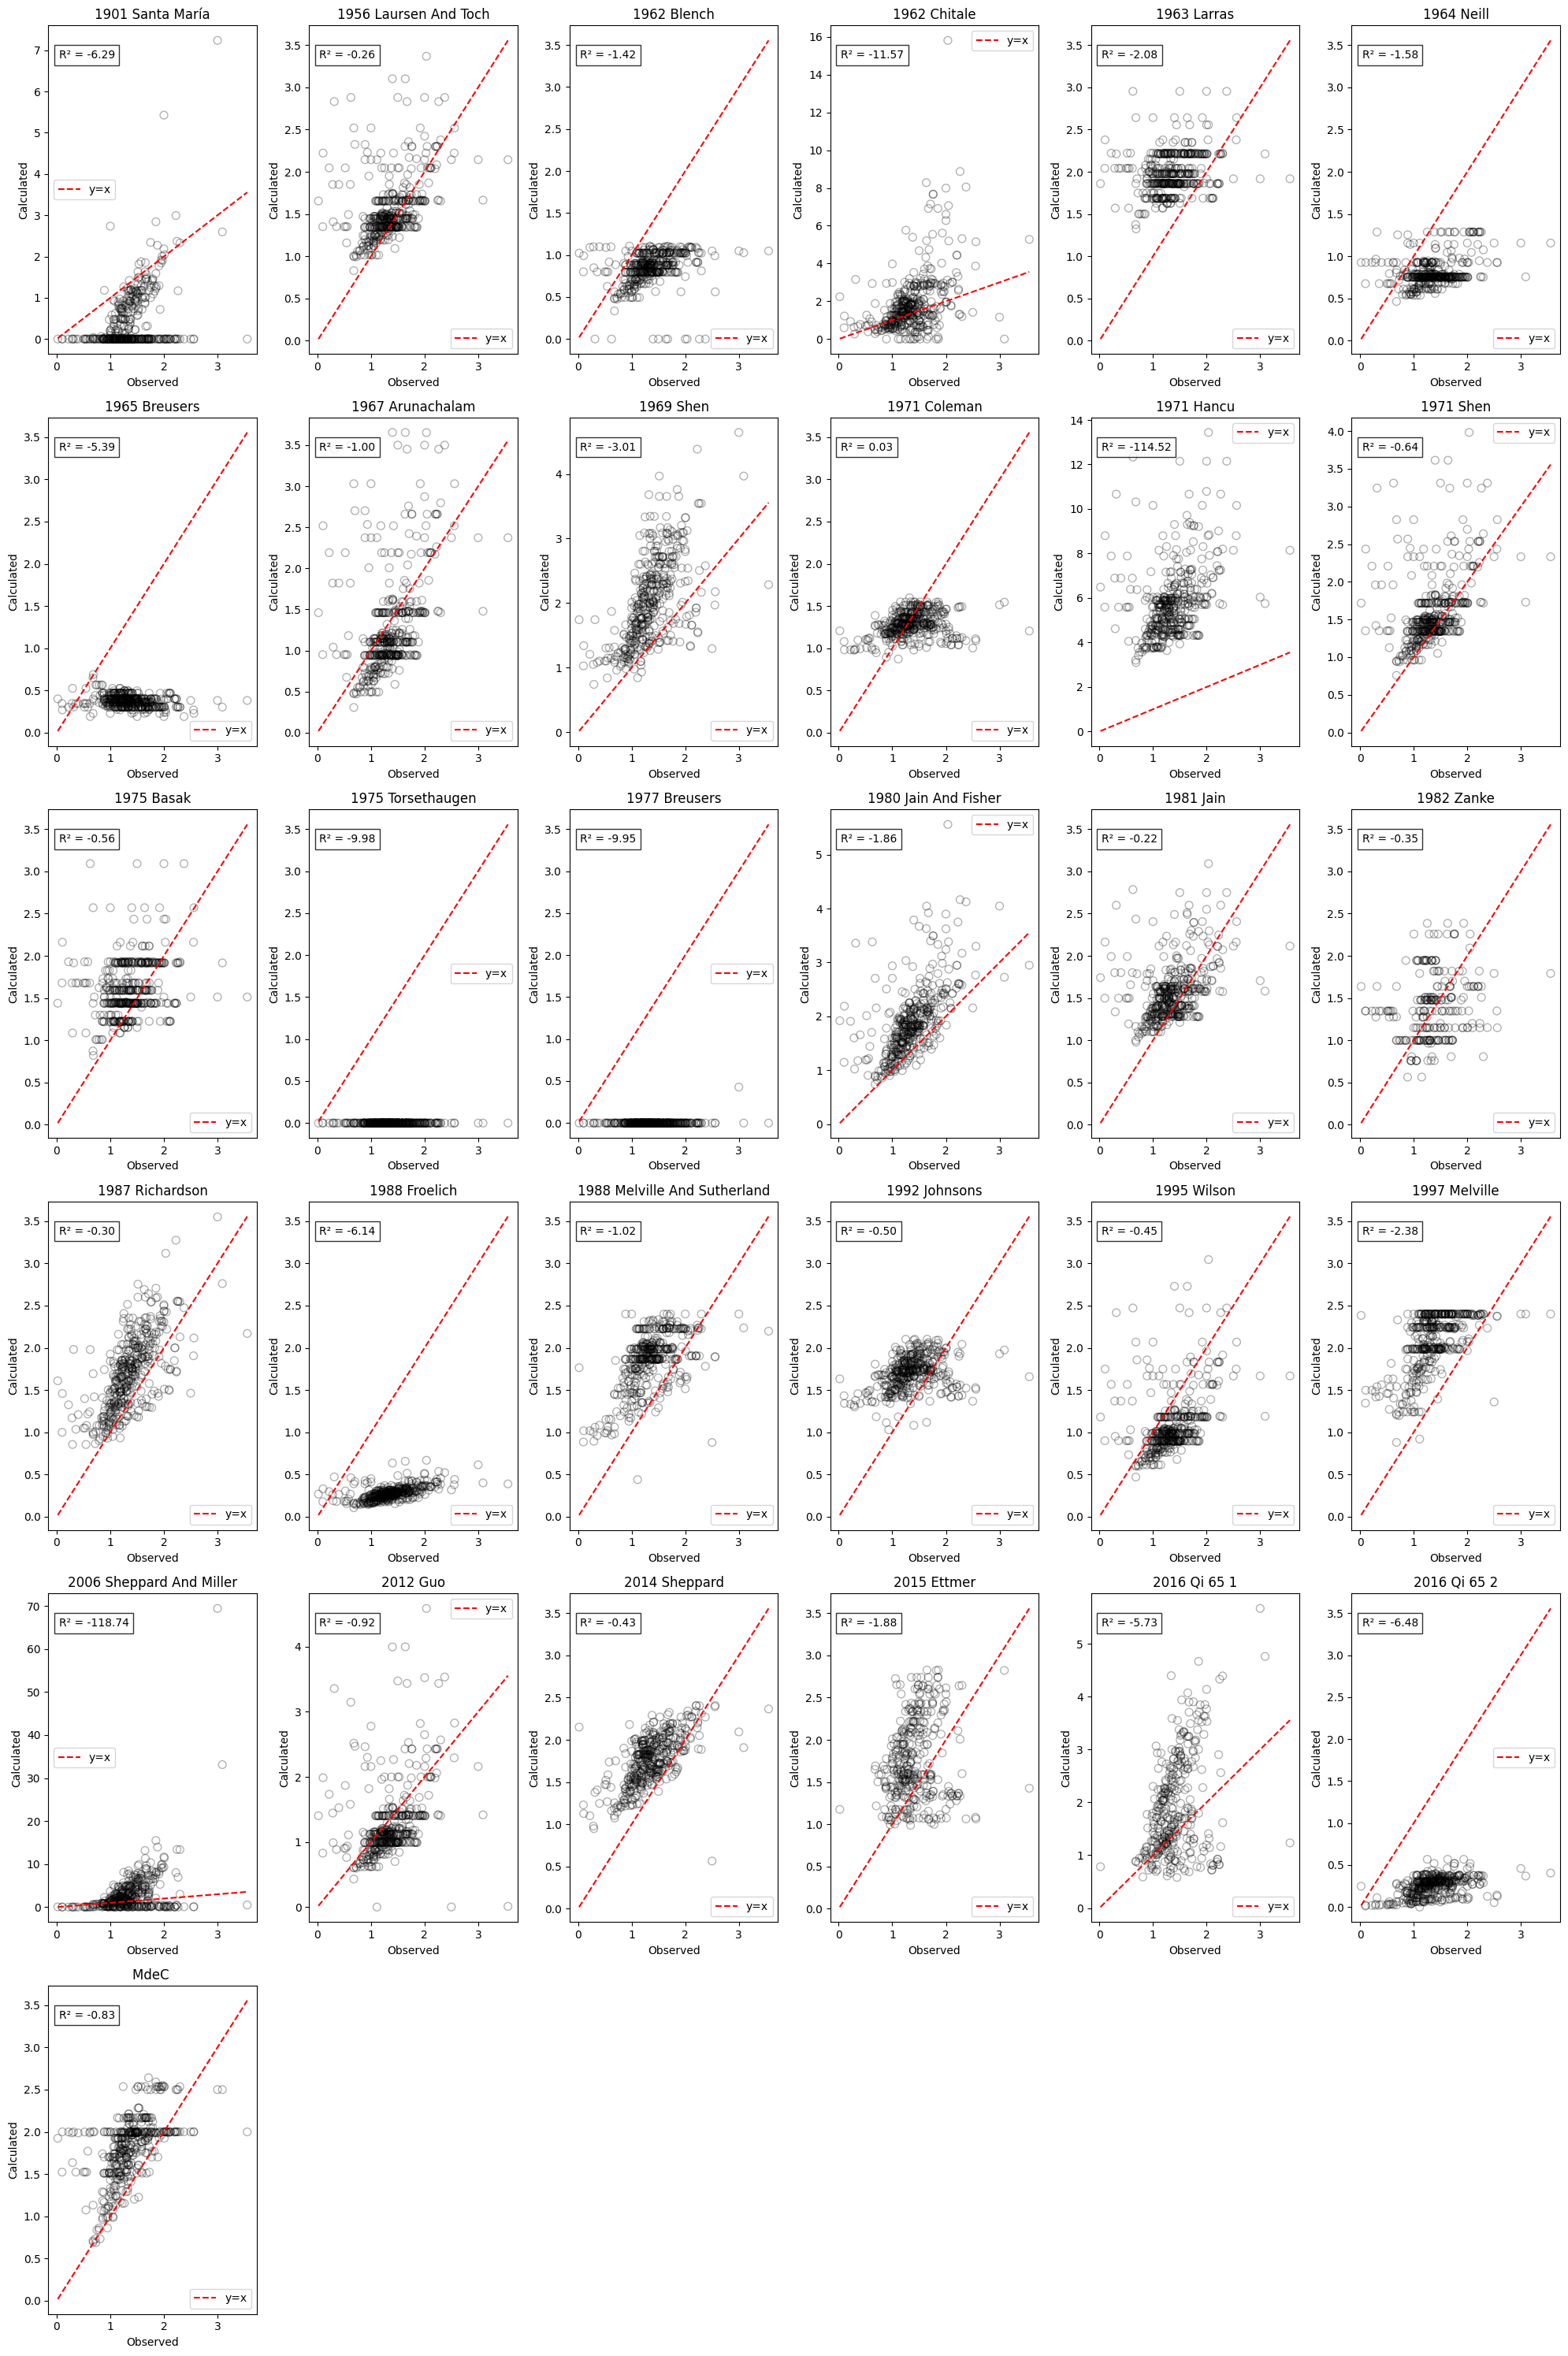

In [52]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# group by the 'equation' column
equations = df_cal['equation'].unique()

# determine the number of rows and columns for the plots
num_equations = len(equations)
num_columns = 6  # set the number of columns for the plots
num_rows = (num_equations // num_columns) + (num_equations % num_columns != 0)
print(f"Generando {num_equations} gráficos en {num_rows} filas y {num_columns} columnas.")
# create a figure with subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
axes = axes.flatten()  # flatten the axes array for easier iteration

# iterate over each equation
for i, equation in enumerate(equations):
    # filter data for the specific equation
    equation_data = df_cal[df_cal['equation'] == equation]

    # extract the relevant columns
    observed = equation_data['obs_dimensionless']
    calculated = equation_data['cal_dimensionless']

    # plot formatted title
    parts = equation.split('_')
    formatted_title = f"{parts[1]} {' '.join(parts[2:]).title()}"

    # calculate r²
    mask = ~np.isnan(observed) & ~np.isnan(calculated)  # consider non-NA values
    obs_filtered = observed[mask]
    cal_filtered = calculated[mask]

    r2 = r2_score(obs_filtered, cal_filtered)
    mae = mean_absolute_error(obs_filtered, cal_filtered)
    rmse = np.sqrt(mean_squared_error(obs_filtered, cal_filtered))


    print(f'{formatted_title} R²= {r2:.1f}, MAE= {mae:.1f}, RMSE= {rmse:.1f}')

    #print(f'{formatted_title} R²= {r2:.2f}, RMSE= {rmse:.2f}')
    #print(f'{formatted_title} R²= {r2:.2f}')

    # create the scatter plot on the appropriate axis
    ax = axes[i]
    ax.scatter(observed, calculated, alpha=0.3, edgecolors='black', facecolors='none', s=50)
    ax.plot([min(observed), max(observed)], [min(observed), max(observed)], color='red', linestyle='--', label='y=x')
    ax.set_xlabel('Observed', fontsize=10)
    ax.set_ylabel('Calculated', fontsize=10)
    ax.set_title(formatted_title, fontsize=12)
    ax.legend()

    # add r² inside the plot
    ax.text(0.05, 0.9, f'R² = {r2:.2f}', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# hide any unused subplots if the number of equations is less than the number of subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# adjust layout and show the plots
plt.tight_layout()
plt.show()

# Model

obj: predict the scour depth

In [53]:
# convert the calculated values by equations in diferents columnns
df_wide = df_cal.pivot(index='id', columns='equation', values='cal_dimensionless').add_prefix('cal_').reset_index()

# merge with df
df_cal = df.merge(df_wide, on='id')

In [54]:
# @title Select predictors (X) and objective (y)

# dataset 1: select only columns containing hydraulic variables for calculating
X1 = df_cal[['b', 'h', 'v', 'd50', 'vcr']]

# dataset 2: select only columns containing calculations of scour
X2 = df_cal.filter(like='cal')

# define the target variable
y = df_cal['obs_dimensionless']

# display both datasets
print('Dataset 1 (X1) - Hydraulic variables')
display(X1)

print('\nDataset 2 (X2) - Calculated scour')
display(X2)

Dataset 1 (X1) - Hydraulic variables


,b,h,v,d50,vcr
0,0.0700,0.20,0.231,0.96,0.364348
1,0.0700,0.07,0.245,0.96,0.364348
2,0.0700,0.07,0.218,0.96,0.364348
3,0.0700,0.07,0.231,0.96,0.364348
4,0.0700,0.07,0.198,0.96,0.364348
...,...,...,...,...,...
418,0.1016,0.10,1.050,1.40,0.432001
419,0.0508,0.10,1.200,1.40,0.432001
420,0.0795,0.10,1.200,1.40,0.432001
421,0.1016,0.10,1.200,1.40,0.432001



Dataset 2 (X2) - Calculated scour


,cal_eq_1901_santa_maría,cal_eq_1956_laursen_and_toch,cal_eq_1962_blench,cal_eq_1962_chitale,cal_eq_1963_larras,cal_eq_1964_neill,cal_eq_1965_breusers,cal_eq_1967_arunachalam,cal_eq_1969_shen,cal_eq_1971_coleman,...,cal_eq_1992_johnsons,cal_eq_1995_wilson,cal_eq_1997_melville,cal_eq_2006_sheppard_and_miller,cal_eq_2012_guo,cal_eq_2014_sheppard,cal_eq_2015_ettmer,cal_eq_2016_qi_65_1,cal_eq_2016_qi_65_2,cal_eq_MdeC
0,0.000000,1.849751,1.098540,1.249651,2.041337,0.925551,0.345175,1.819971,1.266240,1.039056,...,1.405853,1.369668,1.831333,0.062717,1.658262,1.827713,NaN,NaN,0.067756,1.986849
1,0.000000,1.350000,0.800000,0.976208,2.041337,0.675493,0.345175,0.950000,1.313210,1.167731,...,1.556182,0.900000,1.803354,0.056141,0.989347,1.814503,NaN,NaN,0.067621,1.523188
2,0.000000,1.350000,0.800000,0.859479,2.041337,0.675493,0.345175,0.950000,1.221645,1.140777,...,1.518488,0.900000,1.648699,0.051567,0.968670,1.714162,NaN,NaN,0.048844,1.523188
3,0.000000,1.350000,0.800000,0.917137,2.041337,0.675493,0.345175,0.950000,1.266240,1.154069,...,1.537071,0.900000,1.723163,0.054181,0.981041,1.771524,NaN,NaN,0.057884,1.523188
4,0.000000,1.350000,0.800000,0.765498,2.041337,0.675493,0.345175,0.950000,1.151002,1.119032,...,1.488111,0.900000,1.534139,0.045717,0.936381,1.585849,NaN,NaN,0.034935,1.523188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,0.670896,1.343587,0.794446,0.364016,1.859798,0.751781,0.400643,0.940124,2.804868,1.507500,...,1.910013,0.894304,1.984189,3.960542,0.992095,1.762883,2.088118,2.077904,0.303777,1.988919
419,1.631042,1.654149,1.022898,0.000000,2.211686,0.751781,0.303631,1.460344,3.967362,1.548302,...,1.991752,1.180041,2.400000,9.601261,1.403034,2.006558,2.221649,2.899858,0.301021,2.534998
420,1.042225,1.446184,0.880086,0.000000,1.977414,0.751781,0.363201,1.102954,3.344999,1.548302,...,1.973991,0.986497,2.243089,6.142371,1.121544,1.851215,2.221649,2.456284,0.301021,2.167213
421,0.815521,1.343587,0.794446,0.000000,1.859798,0.751781,0.400643,0.940124,3.046557,1.548302,...,1.964331,0.894304,1.984189,4.810828,0.992095,1.744145,2.221649,2.242176,0.301021,1.988919


In [55]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets using indices
train_idx, test_idx = train_test_split(df_cal.index, test_size=0.2, random_state=42)

# apply the same split to both datasets
X1_train, X1_test = X1.loc[train_idx], X1.loc[test_idx]
X2_train, X2_test = X2.loc[train_idx], X2.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# convert to numpy arrays if needed
X1_train_np, X1_test_np = X1_train.to_numpy(), X1_test.to_numpy()
X2_train_np, X2_test_np = X2_train.to_numpy(), X2_test.to_numpy()
y_train_np, y_test_np = y_train.to_numpy(), y_test.to_numpy()

# print shapes to verify
print(f'X1_train shape: {X1_train.shape}, X1_test shape: {X1_test.shape}')
print(f'X2_train shape: {X2_train.shape}, X2_test shape: {X2_test.shape}')
print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

X1_train shape: (338, 5), X1_test shape: (85, 5)
X2_train shape: (338, 31), X2_test shape: (85, 31)
y_train shape: (338,), y_test shape: (85,)


In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score
import seaborn as sns

# @title Train model

#random seed for reproductivity
#np.random.seed(12)

# function to train and evaluate random forest for a given dataset
def evaluate(X_train, X_test, y_train, y_test):

    # convert to numpy arrays
    X_train_np = X_train
    X_test_np = X_test
    y_train_np = y_train
    y_test_np = y_test

    # model
    model_rf = RandomForestRegressor()

    # hyperparameter grid
    param_grid = {'max_depth': [2, 10, 20, 50, 100, 200],
                  #'min_samples_split': [2, 4, 6, 8],
                  #'max_leaf_nodes': [2, 4, 10, 20],
                  #'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                  'n_estimators': [10, 20, 50]
                  }

    # cross-validation
    kf = KFold(n_splits=4, shuffle=True)

    # hyperparameter search
    grid_search = GridSearchCV(estimator=model_rf,
                               param_grid=param_grid,
                               cv=kf,
                               n_jobs=1,
                               verbose=0)

    # train model
    grid_search.fit(X_train_np, y_train_np)

    # best parameters
    best_params = grid_search.best_params_
    print('Best parameters:', best_params)

    # train best model
    model_rf_best = RandomForestRegressor(**best_params)
    model_rf_best.fit(X_train_np, y_train_np)

    # predict on test data
    y_pred = model_rf_best.predict(X_test_np)

    # evaluation metrics
    r2 = r2_score(y_test_np, y_pred)
    rmse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)

    return y_test_np, y_pred, r2, rmse, mae

# train and get results for both datasets
y_test_1, y_pred_1, r2_1, rmse_1, mae_1 = evaluate(X1_train_np, X1_test_np,y_train_np, y_test_np)
y_test_2, y_pred_2, r2_2, rmse_2, mae_2 = evaluate(X2_train_np, X2_test_np,y_train_np, y_test_np)

Best parameters: {'max_depth': 50, 'n_estimators': 50}
Best parameters: {'max_depth': 100, 'n_estimators': 50}


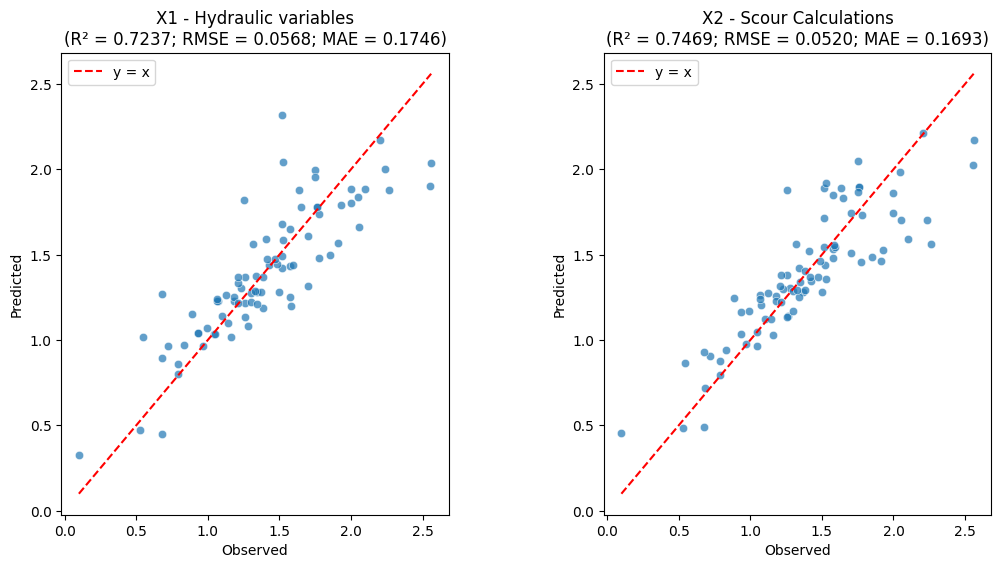

In [37]:
# @title Evaluate model
def plot_results(ax, y_test, y_pred, r2, rmse, mae, title):
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, ax=ax)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    ax.plot(lims, lims, 'r--', label='y = x')
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    ax.legend()
    ax.set_title(f'{title}\n(R² = {r2:.4f}; RMSE = {rmse:.4f}; MAE = {mae:.4f})')

# crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': 0.4})

# graficar ambos resultados
plot_results(axes[0], y_test_1, y_pred_1, r2_1, rmse_1, mae_1, 'X1 - Hydraulic variables')
plot_results(axes[1], y_test_2, y_pred_2, r2_2, rmse_2, mae_2, 'X2 - Scour Calculations')

plt.show()

explain parameters

evaluate model with supercritic flow